In [14]:
import pandas as pd
%load_ext autoreload
%autoreload 2

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc

import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output\movement")

include = [1, 4, 6, 7, 9, 10, 11, 12, 13]

dnt.set_plot_style()
spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)

df = spots_dfs[0]
cycles = [10, 11, 12, 13, 14]
earliest_frames = [25, 43, 63, 80, 23, 36, 17, 50, 3]

print(df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 0it [00:00, ?it/s]

[  0  35  60 110 160 280] 25 246


reading spots dfs: 2it [00:00,  2.11it/s]

[  0  55  90 140 200 350] 0 332


reading spots dfs: 5it [00:03,  1.59it/s]

[  0  65 100 150 225 350] 0 311


reading spots dfs: 7it [00:04,  1.47it/s]

[  0  85 125 170 225 350] 0 325


reading spots dfs: 8it [00:06,  1.10it/s]

[  0  25  60 120 200 280] 0 280


reading spots dfs: 10it [00:07,  1.19it/s]

[  0  50  80 120 200 280] 0 280


reading spots dfs: 11it [00:09,  1.05it/s]

[  0  25  55 100 180 280] 0 241


reading spots dfs: 12it [00:10,  1.02s/it]

[  0  55  90 140 200 350] 0 311


reading spots dfs: 13it [00:12,  1.20s/it]

[  0  10  50 100 150 280] 0 246


reading spots dfs: 14it [00:13,  1.05it/s]

Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'status', 'source', 'is_parent', 'is_child',
       'pseudotime', 'distance', 'cycle_pseudotime', 'dx', 'dy', 'dz', 'dAP',
       'dtheta', 'dtot', 'dAP_abs'],
      dtype='object')


In [13]:
import napari
viewer = napari.Viewer()
df = spots_dfs[-1]
viewer.add_points(df[["frame", "z", "y", "x"]].values, size=df["radius"]*2.2, face_color="cyan", border_color="k", border_width=0.1)
napari.run()

# Show nuclear speeds per nuclear cycle

In [2]:
from itertools import pairwise
from collections import defaultdict

cycle_speeds = defaultdict(list)

for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    spots_dfs[i] = df

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    for j, (start_frame, end_frame) in enumerate(pairwise(min_mvmt_frames)):
        frame_subset = df[(df["frame"] >= start_frame) & (df["frame"] <= end_frame)]

        cycle_speeds[j+10].extend(frame_subset["dtot"].values * 60)


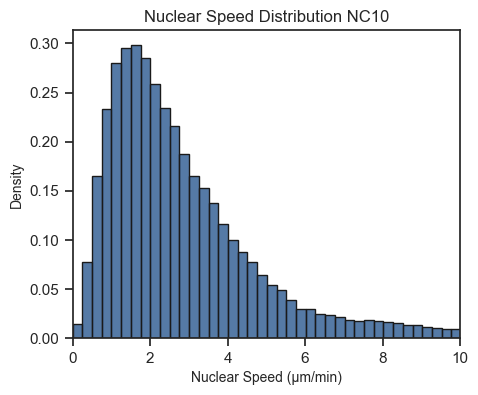

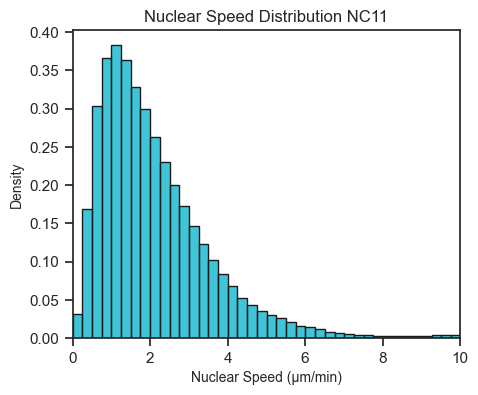

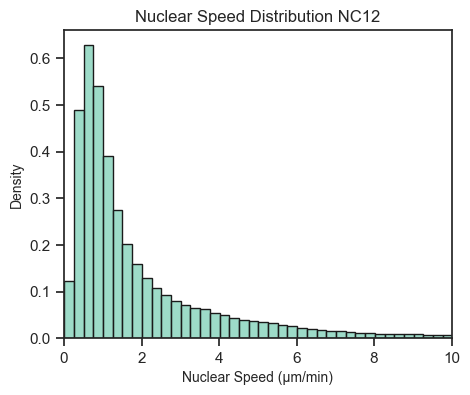

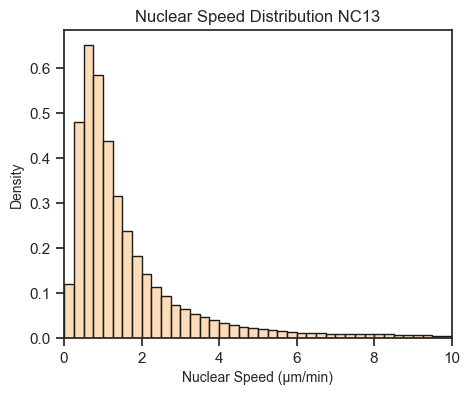

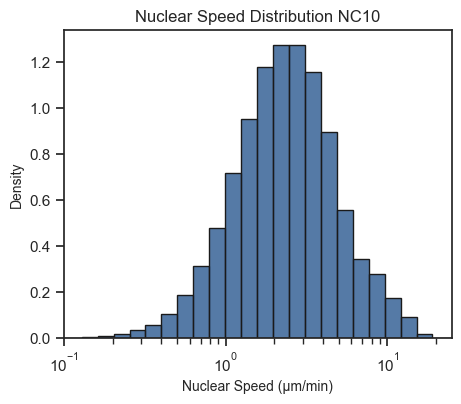

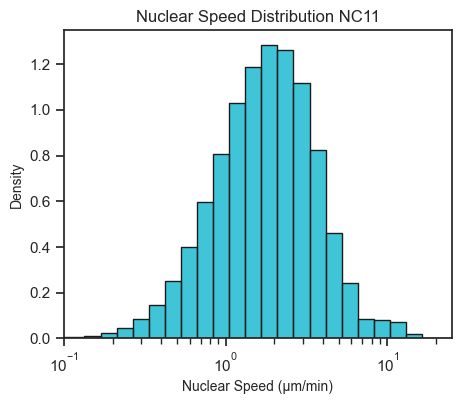

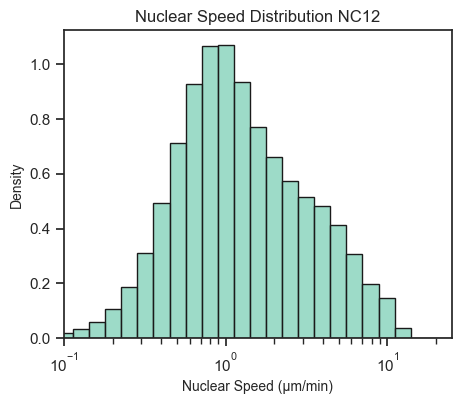

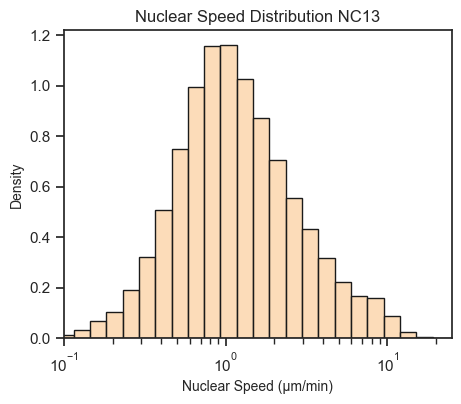

In [3]:
for cycle in [10, 11, 12, 13]:
    plt.figure(figsize=(5, 4))
    sns.histplot(cycle_speeds[cycle], binwidth=0.25, kde=False, color=dnt.palettes.nc[cycle],
                 stat="density", legend=False, common_norm=False, edgecolor="k", linewidth=1)

    plt.xlabel("Nuclear Speed (µm/min)")
    plt.ylabel("Density")
    plt.xlim(0, 10)
    plt.title(f"Nuclear Speed Distribution NC{cycle}")
    plt.savefig(save_path / f"nc{cycle}_nuclear_speed_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

for cycle in [10, 11, 12, 13]:
    plt.figure(figsize=(5, 4))
    sns.histplot(cycle_speeds[cycle], binwidth=0.1, kde=False, color=dnt.palettes.nc[cycle],
                 stat="density", legend=False, common_norm=False, edgecolor="k", linewidth=1, log_scale=(True, False))

    plt.xlabel("Nuclear Speed (µm/min)")
    plt.ylabel("Density")
    plt.xlim(0.1, 25)
    plt.title(f"Nuclear Speed Distribution NC{cycle}")
    plt.savefig(save_path / f"nc{cycle}_nuclear_speed_distribution_log.png", dpi=300, bbox_inches='tight')
    plt.show()

# Show displacement distributions per nuclear cycle

In [4]:
timepoints_dfs = []

for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    spots_dfs[i] = df

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    timepoints_dfs.append(dnt.generate_timepoint_df(df))


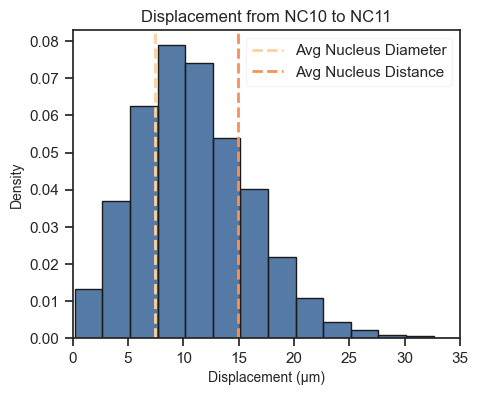

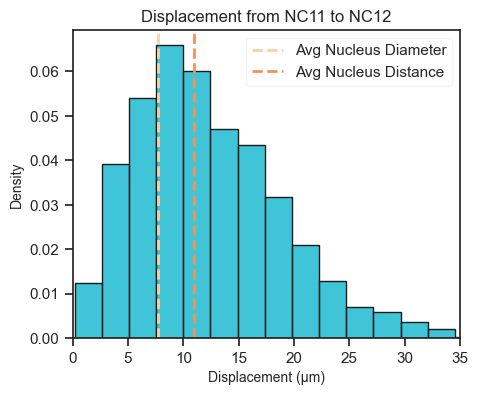

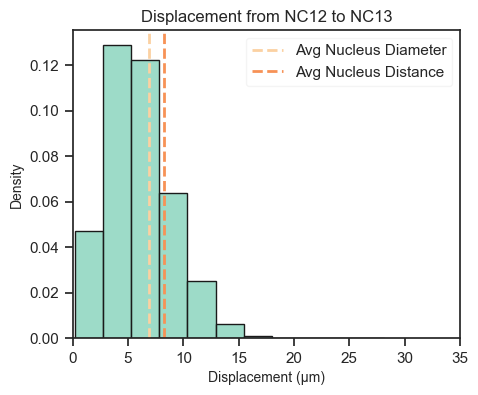

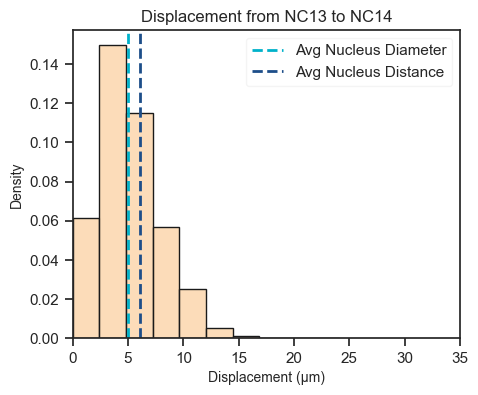

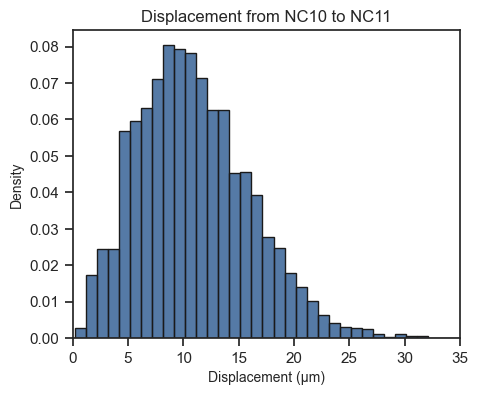

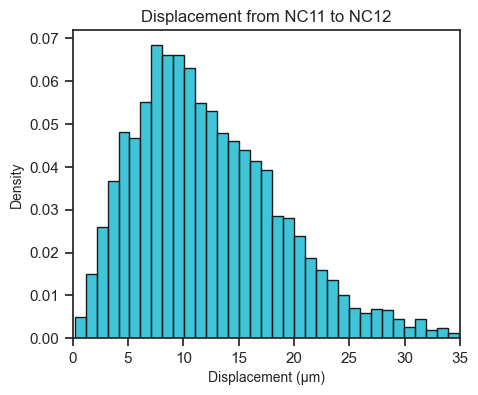

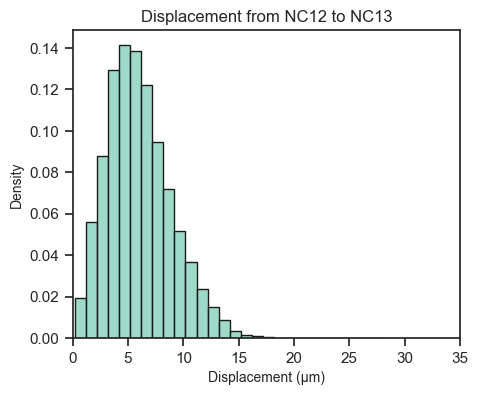

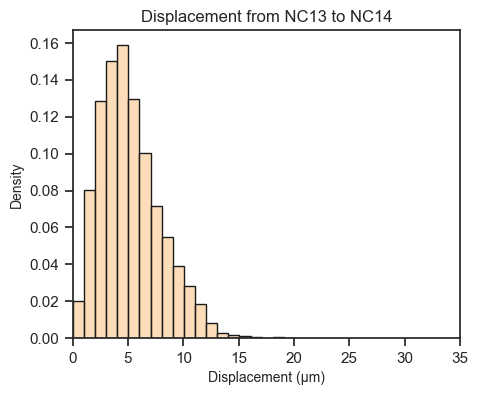

In [5]:
from collections import defaultdict
cycle_dfs = defaultdict(list)

for i, df in enumerate(timepoints_dfs):
    displacements = {}
    for col in ["z", "y", "x"]:
        displacements[col] = df[col] - df["prev_id"].map(df[col])

    df["displacement"] = np.sqrt(displacements["z"]**2 + displacements["y"]**2 + displacements["x"]**2)
    df["prev_cycle"] = df["cycle"] - 1
    # print(displacements)

    for cycle in [11, 12, 13, 14]:
        cycle_df = df[df["cycle"] == cycle]
        cycle_dfs[cycle].append(cycle_df)


for cycle in [11, 12, 13, 14]:
    combined_cycle_df = pd.concat(cycle_dfs[cycle], ignore_index=True)

    cool = (cycle - 1) < 13
    col1 = dnt.palettes.nc[13] if cool else dnt.palettes.nc[11]
    col2 = dnt.palettes.nc[14] if cool else dnt.palettes.nc[10]

    plt.figure(figsize=(5, 4))
    sns.histplot(data=combined_cycle_df, x="displacement", kde=False, binwidth=2.5,
                 color=dnt.palettes.nc[cycle - 1], stat="density", legend=False,
                 common_norm=False, edgecolor="k", linewidth=1)

    plt.axvline(combined_cycle_df["radius"].mean()*2, color=col1, linestyle="--", linewidth=2.0, label="Avg Nucleus Diameter")
    plt.axvline(combined_cycle_df["first_neighbor_distance"].mean(),
                color=col2, linestyle="--", linewidth=2.0, label="Avg Nucleus Distance")


    plt.xlabel("Displacement (µm)")
    plt.ylabel("Density")
    plt.xlim(0, 35)
    plt.title(f"Displacement from NC{cycle-1} to NC{cycle}")
    plt.legend()
    plt.savefig(save_path / f"nc{cycle}_nuclear_displacement_over_time_withlabels.png", dpi=300, bbox_inches='tight')
    plt.show()

for cycle in [11, 12, 13, 14]:
    combined_cycle_df = pd.concat(cycle_dfs[cycle], ignore_index=True)

    plt.figure(figsize=(5, 4))
    sns.histplot(data=combined_cycle_df, x="displacement", kde=False, binwidth=1.0,
                 color=dnt.palettes.nc[cycle - 1], stat="density", legend=False,
                 common_norm=False, edgecolor="k", linewidth=1)

    plt.xlabel("Displacement (µm)")
    plt.ylabel("Density")
    plt.xlim(0, 35)
    plt.title(f"Displacement from NC{cycle-1} to NC{cycle}")
    plt.savefig(save_path / f"nc{cycle}_nuclear_displacement_over_time_withoutlabels.png", dpi=300, bbox_inches='tight')
    plt.show()

# plot initial-final displacement

C:\Users\Harrison\AppData\Local\Temp\ipykernel_23300\4289822153.py:54: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(combined_cycle_df, x="AP", y="dAP", hue="source", palette=dnt.palettes.ap, edgecolor="k", legend=False)


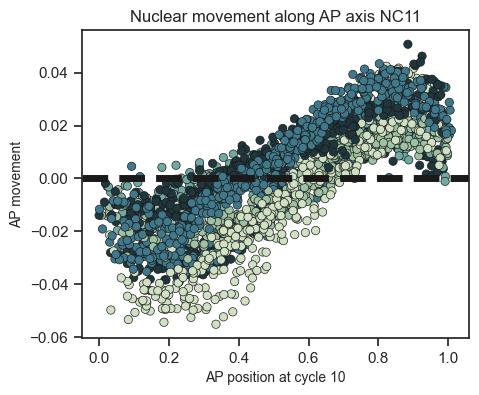

C:\Users\Harrison\AppData\Local\Temp\ipykernel_23300\4289822153.py:54: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(combined_cycle_df, x="AP", y="dAP", hue="source", palette=dnt.palettes.ap, edgecolor="k", legend=False)


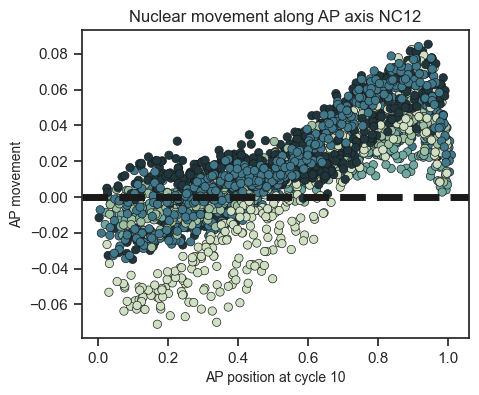

C:\Users\Harrison\AppData\Local\Temp\ipykernel_23300\4289822153.py:54: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(combined_cycle_df, x="AP", y="dAP", hue="source", palette=dnt.palettes.ap, edgecolor="k", legend=False)


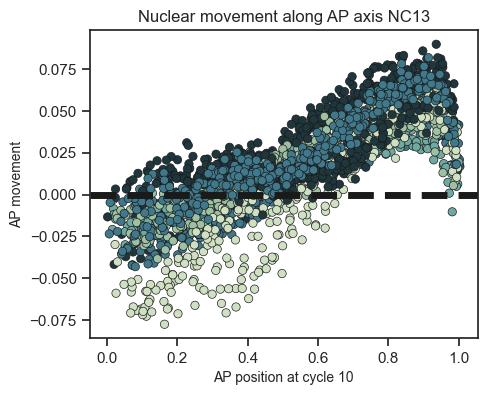

C:\Users\Harrison\AppData\Local\Temp\ipykernel_23300\4289822153.py:54: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(combined_cycle_df, x="AP", y="dAP", hue="source", palette=dnt.palettes.ap, edgecolor="k", legend=False)


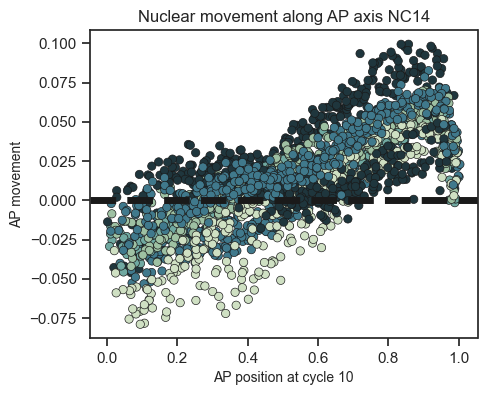

In [7]:
displacement_save_path = save_path / "displacements"

cycle_dfs = defaultdict(list)

for i, df in enumerate(spots_dfs):

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    df = df.copy()
    df["id"] = df.index
    df["first_id"] = df["track_id"].map(df.groupby("track_id")["id"].first())
    df["first_cycle"] = df["track_id"].map(df.groupby("track_id")["cycle"].first())
    df = df[df["first_cycle"] == 10].copy()

    displacements = {}
    for col in ["z", "y", "x", "AP"]:
        displacements[col] = df[col] - df["first_id"].map(df[col])

    df["dAP"] = displacements["AP"]
    df["prev_cycle"] = df["cycle"] - 1

    for j, frame in enumerate(min_mvmt_frames[1:]):
        cycle_df = df[df["frame"] == frame]
        t = cycle_df.groupby("track_id")[["AP", "dAP", "source"]].mean()

        sns.scatterplot(t, x="AP", y="dAP", color=dnt.palettes.nc[j+11], edgecolor="k")

        plt.ylabel("AP movement")
        plt.xlabel("AP position at cycle 10")

        plt.axhline(0, color="k", linestyle="--", linewidth=5)
        plt.title("Nuclear movement along AP axis")
        plt.savefig(displacement_save_path / f"{stems[i]}_nc{j+11}_movement_ap.png", dpi=300, bbox_inches='tight')

        plt.close()

        cycle_dfs[j+11].append(t)

for cycle in [11, 12, 13, 14]:
    combined_cycle_df = pd.concat(cycle_dfs[cycle], ignore_index=True)
    plt.figure(figsize=(5, 4))
    sns.scatterplot(combined_cycle_df, x="AP", y="dAP", color=dnt.palettes.nc[cycle], edgecolor="k")
    plt.ylabel("AP movement")
    plt.xlabel("AP position at cycle 10")
    plt.axhline(0, color="k", linestyle="--", linewidth=5)
    plt.title(f"Nuclear movement along AP axis NC{cycle}")
    plt.savefig(displacement_save_path / f"all_nc{cycle}_movement_ap.png",
                dpi=300, bbox_inches='tight')
    plt.close()

for cycle in [11, 12, 13, 14]:
    combined_cycle_df = pd.concat(cycle_dfs[cycle], ignore_index=True)
    plt.figure(figsize=(5, 4))
    sns.scatterplot(combined_cycle_df, x="AP", y="dAP", hue="source", palette=dnt.palettes.ap, edgecolor="k", legend=False)
    plt.ylabel("AP movement")
    plt.xlabel("AP position at cycle 10")
    plt.axhline(0, color="k", linestyle="--", linewidth=5)
    plt.title(f"Nuclear movement along AP axis NC{cycle}")
    plt.savefig(displacement_save_path / f"by_source_all_nc{cycle}_movement_ap.png",
                dpi=300, bbox_inches='tight')
    plt.show()


In [93]:
import napari
df = spots_dfs[-2]
viewer = napari.Viewer(ndisplay=3)
color = [dnt.palettes.nc[cycle] for cycle in df["cycle"].values]
viewer.add_points(df[["frame", "z", "y", "x"]].values, size=df["radius"]*2.2, face_color=color, border_color="k", border_width=0.1)
napari.run()

In [24]:
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import pandas as pd

regressions = defaultdict(list)

for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    spots_dfs[i] = df

    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    df_subset = df[df["frame"].isin(min_mvmt_frames)]
    t = df_subset.groupby(["track_id", "cycle"])[["AP"]].mean().unstack()


    """
    Plot nuclear movement along AP axis
    """
    for cycle in [11, 12, 13, 14]:
        plt.scatter(t.loc[:, ("AP", 10)], t.loc[:, ("AP", cycle)] - t.loc[:, ("AP", 10)], color=dnt.palettes.nc[cycle], label=cycle)

    plt.legend(title="Nuclear Cycle")
    plt.ylabel("AP movement")
    plt.xlabel("AP position at cycle 10")
    plt.axhline(0, color="k", linestyle="--", linewidth=5)
    plt.title("Nuclear movement along AP axis")

    plt.savefig(save_path / f"{stems[i]}_nc_movement_ap.png", dpi=300)

    plt.close()

    for cycle in [11, 12, 13, 14]:
        plt.scatter(t.loc[:, ("AP", cycle-1)], t.loc[:, ("AP", cycle)] - t.loc[:, ("AP", cycle-1)], color=dnt.palettes.nc[cycle], label=cycle)
        plt.ylabel("AP movement")
        plt.xlabel(f"AP position at cycle {cycle-1}")
        plt.axhline(0, color="k", linestyle="--", linewidth=5)
        plt.title(f"{stems[i]} - NC{cycle}")

        save_folder = save_path / "per_cycle" / stems[i]
        save_folder.mkdir(parents=True, exist_ok=True)

        plt.savefig(save_folder / f"{stems[i]}_nc{cycle}_movement_ap.png", dpi=300)

        plt.close()

    for cycle in [11, 12, 13, 14]:
        plt.scatter(t.loc[:, ("AP", 10)], t.loc[:, ("AP", cycle)] - t.loc[:, ("AP", 10)], color=dnt.palettes.nc[cycle], label=cycle)
        plt.ylabel("AP movement")
        plt.ylim(-0.03, 0.08)
        plt.xlabel(f"AP position at cycle {cycle-1}")
        plt.axhline(0, color="k", linestyle="--", linewidth=5)
        plt.title(f"{stems[i]} - NC{cycle}")

        save_folder = save_path / f"by_nc{cycle}"
        save_folder.mkdir(parents=True, exist_ok=True)

        plt.savefig(save_folder / f"{stems[i]}_nc{cycle}_total_movement_ap.png", dpi=300)

        plt.close()

    """
    Fit linear regression to movement data
    """

    for cycle in [11, 12, 13, 14]:
        X = t.loc[:, ("AP", 10)].values.reshape(-1, 1)
        y = (t.loc[:, ("AP", cycle)] - t.loc[:, ("AP", 10)]).values

        # remove nan from x and y
        mask = ~np.isnan(X).flatten() & ~np.isnan(y)
        X = X[mask]
        y = y[mask]

        model = LinearRegression().fit(X, y)
        regressions["cycle"].append(cycle)
        regressions["slope"].append(model.coef_[0])
        regressions["intercept"].append(model.intercept_)
        regressions["r2"].append(model.score(X, y))
        regressions["dataset"].append(i)
        regressions["trk"].append(df["trk"].values[0])

    print(np.mean(t.loc[:, ("AP", 13)] - t.loc[:, ("AP", 10)]))

regressions = pd.DataFrame(regressions)

0.03338149025407605
0.012353418416375798
0.01581218472289465
0.016411506060269556
0.02112790588021235
-0.0027890622196605885
0.021588852912290832
0.021689885015454092
0.01942358545773988


C:\Users\Harrison\AppData\Local\Temp\ipykernel_23300\3483626263.py:1: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(data=regressions, x="cycle", y="slope", errorbar=None, hue="trk", palette=list(dnt.palettes.nc.values()), edgecolor="k", linewidth=1.5)


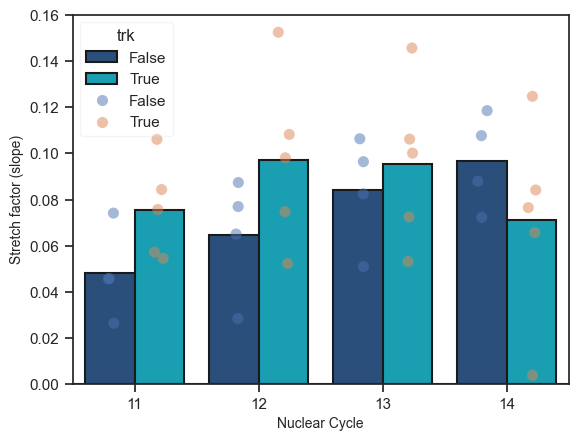

C:\Users\Harrison\AppData\Local\Temp\ipykernel_23300\3483626263.py:12: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(data=regressions, x="cycle", y="shift", errorbar=None, hue="trk", palette=list(dnt.palettes.nc.values()), edgecolor="k", linewidth=1.5)


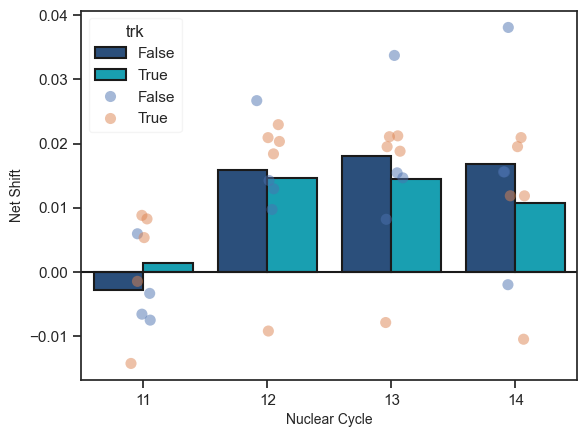

In [23]:
sns.barplot(data=regressions, x="cycle", y="slope", errorbar=None, hue="trk", palette=list(dnt.palettes.nc.values()), edgecolor="k", linewidth=1.5)
sns.stripplot(data=regressions, x="cycle", y="slope", hue="trk", alpha=0.5, size=8, dodge=True)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Stretch factor (slope)")
plt.axhline(0, color="k", linestyle="-", linewidth=1.5)
plt.savefig(save_path / f"nc_movement_ap_slopes.png", dpi=300)
plt.show()

regressions["shift"] = regressions["intercept"] + regressions["slope"] * 0.5

sns.barplot(data=regressions, x="cycle", y="shift", errorbar=None, hue="trk", palette=list(dnt.palettes.nc.values()), edgecolor="k", linewidth=1.5)
sns.stripplot(data=regressions, x="cycle", y="shift", hue="trk", alpha=0.5, size=8, jitter=True)

plt.xlabel("Nuclear Cycle")
plt.ylabel("Net Shift")
plt.axhline(0, color="k", linestyle="-", linewidth=1.5)
plt.savefig(save_path / f"nc_movement_ap_shift.png", dpi=300)
plt.show()

In [86]:
for k in range(6):
    df = spots_dfs[k]
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)
    df_subset = df[df["frame"].isin(min_mvmt_frames)]

    fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharex=True, sharey=True)

    for i, c1 in enumerate(range(10, 14)):
        for j, c2 in enumerate(range(11, 15)):

            ax = axes[c2 - 11, c1 - 10]

            if c2 <= c1:
                ax.remove()
                continue

            if c1 == 10:
                ax.set_ylabel(f"NC{str(c2)} Displacement")

            if c2 == 14:
                ax.set_xlabel(f"NC{str(c1)} Position")

            ax.axhline(0, color="k", linestyle="--", linewidth=3)

            # df_subset = df[df["cycle"].isin([c1, c2])]
            t = df_subset.groupby(["track_id", "cycle"])[["AP"]].mean().unstack()

            ax.scatter(t.loc[:, ("AP", c1)], t.loc[:, ("AP", c2)] - t.loc[:, ("AP", c1)], color=dnt.palettes.nc[c2])

    plt.savefig(save_path / f"{stems[k]}_nc_movement_ap_grid.png", dpi=300)
    plt.close()


In [89]:
plt.show()
for k in range(6):
    df = spots_dfs[k]
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)
    df_subset = df[df["frame"].isin(min_mvmt_frames)]

    fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)

    for i, c1 in enumerate(range(10, 14)):
        c2 = c1 + 1

        ax = axes[i]

        if c1 == 10:
            ax.set_ylabel(f"NC Displacement")

        ax.set_xlabel(f"NC{str(c1)} Position")

        ax.axhline(0, color="k", linestyle="--", linewidth=3)

        df_subset = df[df["cycle"].isin([c1, c2])]
        t = df_subset.groupby(["track_id", "cycle"])[["AP"]].mean().unstack()

        ax.scatter(t.loc[:, ("AP", c1)], t.loc[:, ("AP", c2)] - t.loc[:, ("AP", c1)], color=dnt.palettes.nc[c2])

    plt.savefig(save_path / f"{stems[k]}_nc_movement_per_cycle.png", dpi=300)
    plt.close()

In [104]:

for k in range(6):
    df = spots_dfs[k]
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)
    df_subset = df[df["frame"].isin(min_mvmt_frames)]

    fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=False)
    plt.tight_layout(pad=2.0)

    for i, c1 in enumerate(range(10, 14)):

        """
        Plot displacement
        """
        c2 = c1 + 1
        ax = axes[1, i]

        ax.set_ylim(-0.03, 0.06)
        ax.set_yticks(np.arange(-0.03, 0.07, 0.03))

        if c1 == 10:
            ax.set_ylabel(f"NC Displacement")

        ax.set_xlabel(f"NC{str(c1)} Position")

        ax.axhline(0, color="k", linestyle="--", linewidth=3)

        df_subset = df[df["cycle"].isin([c1, c2])]
        t = df_subset.groupby(["track_id", "cycle"])[["AP"]].mean().unstack()

        ax.scatter(t.loc[:, ("AP", c1)], t.loc[:, ("AP", c2)] - t.loc[:, ("AP", c1)], color=dnt.palettes.nc[c2])

        """
        Plot nuclear cycle division timing
        """

        ax = axes[0, i]

        if c2 < 14:
            cycle_df = df[df["cycle"] == c2]
            cycle_df = cycle_df[cycle_df["distance"] < 3.0]
            cycle_times = cycle_df.groupby("track_id")["time_since_nc11"].min()

        else:
            cycle_df = df[df["cycle"] == 13]
            cycle_df = cycle_df[cycle_df["distance"] < 3.0]
            cycle_times = cycle_df.groupby("track_id")["time_since_nc11"].max()

        ap_positions = cycle_df.groupby("track_id")["AP"].mean()
        ap_bin = ap_positions // 0.1 * 0.1 + 0.05

        mean_div_time = cycle_times.mean()
        ax.set_ylim(mean_div_time - 2.0, mean_div_time + 2.0)

        sns.lineplot(x=ap_bin, y=cycle_times, color=dnt.palettes.nc[c2], errorbar=None, ax=ax, linewidth = 8.0)

        if c1 == 10:
            ax.set_ylabel(f"Time since NC11 (min)")
        else:
            ax.set_ylabel("")

    plt.savefig(save_path / f"{stems[k]}_nc_movement_per_cycle_with_division.png", dpi=300)
    plt.show()

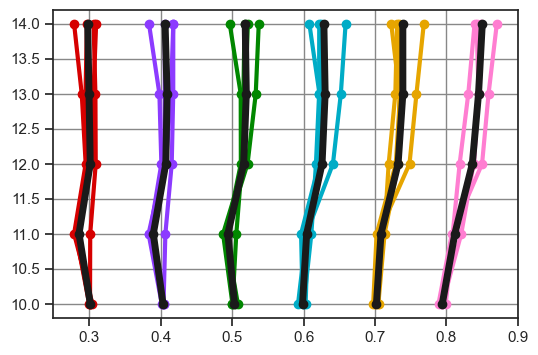

In [13]:
plt.show()

colors = cc.glasbey_dark[:6]

fig, axes = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True)

all_locs = defaultdict(list)
positions = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for k in range(4):
    df = spots_dfs[k]
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)
    df_subset = df[df["frame"].isin(min_mvmt_frames)]

    for i, position in enumerate(positions):

        df_subset.groupby(["track_id", "cycle"])[["AP"]].mean().unstack()
        c10_df = df_subset[df_subset["cycle"] == 10]
        c10_tids = c10_df[c10_df["AP"].between(position - 0.05, position + 0.05)]["track_id"].unique()
        df_calc = df_subset[df_subset["track_id"].isin(c10_tids)]
        df_calc = df_calc[df_calc["cycle"].isin([10, 11, 12, 13, 14])]

        avg_locations = df_calc.groupby("cycle")["AP"].mean().values

        plt.plot(avg_locations, range(10, 15), marker='o', label=f"AP {position:.1f}", linewidth=3.0, color=colors[i])

        all_locs[position].append(avg_locations)


for position in positions:
    all_locs[position] = np.mean(all_locs[position], axis=0)
    plt.plot(all_locs[position], range(10, 15), marker='o', label=f"AP {position:.1f} (mean)", linewidth=5.0, color='k')

plt.grid(color="#88888888")
plt.show()
